## Jupyter (Python) notebook to perform main empirical analyses and to generate figures 2, 3, and S3.  


In [6]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy
import matplotlib
import geopandas as gp
import pandas as pd
from scipy import stats as stats
import textwrap
import matplotlib as matplotlib
import warnings
warnings.filterwarnings("ignore")

### Load data

See the `download_and_extract_data` notebook for procedures to generate these datasets.

In [7]:
et = pd.read_csv('../data/et_sites.csv', index_col=0, parse_dates=True)
evi = pd.read_csv('../data/evi_sites.csv', index_col=0, parse_dates=True)
pet = pd.read_csv('../data/pet_prism_hargreaves.csv', index_col=0, parse_dates=True)
precip = pd.read_csv('../data/precip_sites.csv', index_col=0, parse_dates=True)
discharge_df = pd.read_csv('../data/discharge_df.csv', index_col=0, parse_dates=True)
discharge_df['00000000'] = np.nan
sites = gp.read_file('../data/sites.shp').set_index('gauge_id')
sites['gauge_id'] = sites.index

In [8]:
# for water years 2002 - 2013
years = range(2001, 2013)
# lists to save dataframes
p_winters = []
s_ends = []
evi_summers = []
pet_summers = []
# start day wet season, end day wet season, end day summer
sdmonth = '10-1-'
edmonth = '3-30-'
esummermonth = '9-30-'
for j,year in enumerate(years): 
    # extract water year data
    sd = pd.to_datetime(sdmonth + str(year))
    ed = pd.to_datetime(edmonth + str(year+1))
    esummer = pd.to_datetime(esummermonth + str(year+1))
    wyrain = precip[(precip.index >= sd)&(precip.index<= ed)]
    wyq = discharge_df.loc[(discharge_df.index >= sd)&(discharge_df.index<= ed)]
    winteret = et.loc[(et.index>=sd)&(et.index<=ed)]
    summerevi = evi.loc[(evi.index>ed)&(evi.index<=esummer)]
    summerpet = pet.loc[(pet.index>ed)&(pet.index<=esummer)]
    # get cumulative storage, precip, and summer EVI
    s = wyrain.cumsum() - wyq.cumsum() - winteret.cumsum()
    p = wyrain.cumsum()
    evimean = summerevi.mean()
    petmean = summerpet.mean()
    colorder = p.columns
    # create single row dataframes with end of season values
    p_winters.append(pd.DataFrame(np.reshape(p.values[-1,:], newshape=(1,len(colorder))), columns=colorder, index=[year+1]))
    s_ends.append(pd.DataFrame(np.reshape(s[colorder].values[-1,:], newshape=(1,len(colorder))), columns=colorder, index=[year+1]))
    evi_summers.append(pd.DataFrame(np.reshape(evimean[colorder].values, newshape=(1,len(colorder))), columns=colorder, index=[year+1]))
    pet_summers.append(pd.DataFrame(np.reshape(petmean[colorder].values, newshape=(1,len(colorder))), columns=colorder, index=[year+1]))


# combine single row dataframes for winter P, end of winter storage, and summer EVI
p_winter = pd.concat(p_winters)
s_end = pd.concat(s_ends)
evi_summer = pd.concat(evi_summers)
pet_summer = pd.concat(pet_summers)

### Reshape data for Figure 3

In [9]:
storagerho = []
storagep = []
storagesig = []
petrho = []
petp = []
petsig = []
colorder = p_winter.columns
for site in colorder:
    if site=='00000000':
        storagerho.append(-1)
        storagep.append(1)
        storagesig.append('False')
        rho, p = scipy.stats.spearmanr(pet_summer[site].values, evi_summer[site].values,nan_policy='omit')
        petrho.append(rho)
        petp.append(p)
        if p<.05: 
            petsig.append('True') 
        else: 
            petsig.append('False')
        continue
    rho, p = scipy.stats.spearmanr(pet_summer[site].values, evi_summer[site].values,nan_policy='omit')
    petrho.append(rho)
    petp.append(p)
    if p<.05: 
        petsig.append('True') 
    else: 
        petsig.append('False')
    rho, p = scipy.stats.spearmanr(p_winter[site].values, s_end[site].values,nan_policy='omit')
    storagerho.append(rho)
    storagep.append(p)
    if p<.05: 
        storagesig.append('True') 
    else: 
        storagesig.append('False')
storageresults = pd.DataFrame.from_dict({'id':colorder, 
                                         'value':storagerho,
                                         'p-value':storagep,
                                         'variable':'Storage', 
                                         'Significant':storagesig
                                        })
storageresults.sort_values(by=['value'], inplace=True)
order = storageresults.id
petresults = pd.DataFrame.from_dict({'id':colorder, 
                                         'value':petrho,
                                         'p-value':petp,
                                         'variable':'EVI', 
                                         'Significant':petsig
                                        })
# longform dataframe with sensitivity results
results = pd.concat([petresults, storageresults])
results.id = results.id.astype('str')

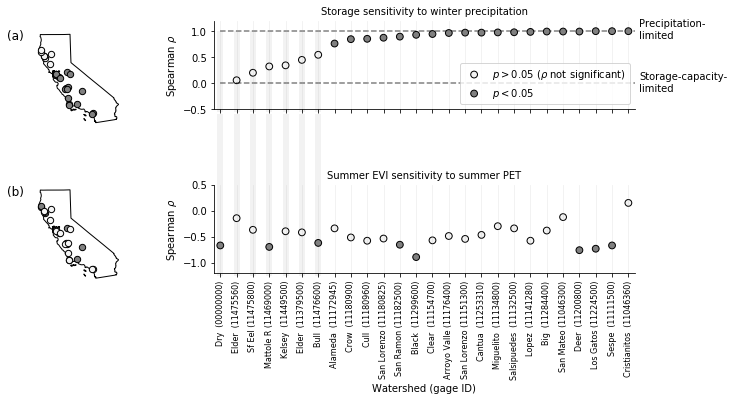

In [10]:
import textwrap
import matplotlib as matplotlib
# Get pretty names for catchments
basins_poly = gp.read_file('../data/basins/basins18_utm.shp')
dry_poly = gp.read_file('../data/dry_creek_polygon/dry.shp')
sitenames = [textwrap.fill(sites.STATION_NM.loc[sites.gauge_id==site].values[0] + ' (' + str(site) + ')',20)  for site in order.values]
sitenames = [item.replace(' C ', ' Creek ') for item in sitenames]
sitenames = [item.replace(' CA ', '') for item in sitenames]
sitenames = [sitenames[i].split(' ')[0] + ' ' 
             + sitenames[i].split(' ')[1] + ' (%s)'%(str(order.values[i]))
             for i in range(len(sitenames))]
sitenames = [sitenames[i].title() for i in range(len(sitenames))]
sitenames = [item.replace('Creek', '') for item in sitenames]
namedict = {}
for i,gageid in enumerate(order.values):
    namedict[gageid] = sitenames[i]

pal = sns.color_palette("gray", )
g = sns.factorplot(y='value',x='id', hue = 'Significant', row='variable',
    data=results, kind='point', join=False, order=order, sharey=False,
    size=2.7, aspect=2.5, row_order=['Storage', 'EVI'],
    hue_order=['False', 'True'], color = 'grey', legend=False)

g.fig.subplots_adjust(hspace=-15)
ax = g.axes.flatten()[0]
plt.setp(ax.collections, edgecolors=['k'], linewidths=[1])
ax.set_xticklabels(['' for i in sitenames])
for tick in ax.get_xticklabels():
    tick.set(color='w')
ax.set_ylabel(r'Spearman $\rho$')
ax.set_ylim([-.25, 1.1])
ax.set_title('Storage sensitivity to winter precipitation',fontsize=10)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, [r'$p>0.05$ ($\rho$ not significant)', r'$p<0.05$'])
ax.plot([0,100],[1,1],'--k',alpha=0.5, zorder=1)
ax.plot([0,100],[0,0],'--k',alpha=0.5, zorder=1)
ax.set_ylim([-0.5,1.2])
ax.set_xlim([-0.4,len(sitenames)-1+0.4])
ax.grid(axis='x',alpha=0.2)

for i in range(len(results.loc[(results.variable=='Storage')&(results.Significant=='False')])):
    ax.plot([i,i],[-0.5,.95],clip_on=False,zorder=-100, c='grey', alpha=0.1,lw=6)
ax.annotate('Precipitation-\nlimited', (1.01,.8), xycoords= 'axes fraction')
ax.annotate('Storage-capacity-\nlimited', (1.01,.2), xycoords= 'axes fraction')

ax = g.axes.flatten()[1]
plt.setp(ax.collections, edgecolors=['k'], linewidths=[1])
ax.set_ylabel(r'Spearman $\rho$')
ax.set_title('Summer EVI sensitivity to summer PET',fontsize=10)
plt.setp(ax.collections, edgecolors=['k'], linewidths=[1])
ax.set_xticklabels(sitenames)
for tick in ax.get_xticklabels():
    tick.set(rotation=90,fontsize=8)
ax.set_xlabel('\n USGS watershed')
ax.set_xlabel('')
# ax.plot([0,100],[1,1],'--k',alpha=0.5, zorder=0)
# ax.plot([0,100],[0,0],'--k',alpha=0.5,zorder=0)
ax.set_ylim([-1.2,0.5])
ax.grid(axis='x',alpha=0.2)
for i in range(len(results.loc[(results.variable=='Storage')&(results.Significant=='False')])):
    ax.plot([i,i],[-1.2,1.8],clip_on=False,zorder=-10, c='grey', alpha=0.1,lw=6)
ax.set_xlabel('Watershed (gage ID)')
basin_poly_list = []
for gage in order.values:
    if gage=='00000000':
        basin_poly_list.append(dry_poly.geometry.values[0].centroid)
        continue
    basin_poly_list.append(basins_poly.loc[basins_poly.SITE_NO==str(gage)].geometry.values[0].centroid)

basin_gdf = gp.GeoDataFrame(sitenames, geometry = basin_poly_list, columns = ['name'])
basin_gdf['id'] = order.values
# maps
mapsize=40
ax = g.fig.add_axes([-0.3,0.25,0.25,0.25])
ca_shp = gp.read_file('../data/CA.shp')
ca_shp.plot(ax=ax, edgecolor='k', color='w')
for i,row in basin_gdf.iterrows():
    sig = results.loc[(results.variable=='EVI')&(results.id==row.id)].Significant.values[0]
    if sig=='False':
        ax.scatter(row.geometry.x, row.geometry.y, edgecolors='k', s=mapsize, c='whitesmoke', linewidth=1.,zorder=100)
    else:
        ax.scatter(row.geometry.x, row.geometry.y, edgecolors='k', s=mapsize, c='grey', linewidth=1.)
sns.despine(ax=ax, left=True, bottom=True) 
ax.set_xticks([])
ax.set_yticks([])
ax.annotate('(b)', (-.3,.9), xycoords= 'axes fraction', fontsize=12)

ax = g.fig.add_axes([-0.3,0.65,0.25,0.25])
ca_shp.plot(ax=ax, edgecolor='k', color='w')
for i,row in basin_gdf.iterrows():
    sig = results.loc[(results.variable=='Storage')&(results.id==row.id)].Significant.values[0]
    if sig=='False':
        ax.scatter(row.geometry.x, row.geometry.y, edgecolors='k', s=mapsize, c='whitesmoke', linewidth=1., zorder=100)
    else:
        ax.scatter(row.geometry.x, row.geometry.y, edgecolors='k', s=mapsize, c='grey', linewidth=1.)
sns.despine(ax=ax, left=True, bottom=True) 
ax.set_xticks([])
ax.set_yticks([])
ax.annotate('(a)', (-.3,.9), xycoords= 'axes fraction', fontsize=12)
plt.tight_layout()
plt.savefig('../plots/FigS6.png', bbox_inches="tight",  dpi=300)
sns.reset_orig()